In [31]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os
from AddUtil.DataUtil import Process
from AddUtil.ModelUtil import HyperTuner
from AddUtil.GraphicsUtil import Visualizer
import timeit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [3]:
SEED = 42

# (I) Data Info

In [4]:
# load data
abs_path = os.getcwd()
path = os.path.join(abs_path, 'data', 'Vehicle Coupon Recommendation.csv') 
data = pd.read_csv(path)

In [3]:
data.head(5)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

# (III) Data Processing

## (3.1) Missing values

In [5]:
Process.get_missing_values(data)

['car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [6]:
df = Process.fill_missing_val(data)

In [7]:
Process.get_missing_values(df)

['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

## (3.2) Categorical Features

In [8]:
# get categorical variables
Process.get_cat_var(data)

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [9]:
# Encode all categorical variables except: 'time', 'expiration', 'age' 
df = Process.encode_cat_var(df)

In [10]:
# Now there are no missing values
Process.get_missing_values(df)

[]

In [11]:
# ecnode time
time_dict = {}

for i in df['time']:
    l = len(i)

    if i[-2:] == 'PM':
        time =  int(i[:l-2]) + 12
    else:
        time = int(i[:l-2])
    
    time_dict[i] = time

df['time'].replace(time_dict, inplace=True)

In [12]:
df['time'].unique()

array([14, 10, 18,  7, 22], dtype=int64)

In [13]:
# encode expiration
exp_dict = {
    df['expiration'].unique()[0]: 24, 
    df['expiration'].unique()[1]: 2}
df['expiration'].replace(exp_dict, inplace=True)


In [14]:
df['expiration'].unique()

array([24,  2], dtype=int64)

In [15]:
# encode age
age_dict = {
    'below21': 16,
    '21': 21,
    '26': 26,
    '31': 31,
    '36': 36,
    '41': 41,
    '46': 46,
    '50plus': 51
}

df['age'].replace(age_dict, inplace=True)

In [16]:
df['age'].unique()

array([21, 46, 26, 31, 41, 51, 36, 16], dtype=int64)

## (3.3) Splitting

In [17]:
# get features and labels

target = Process.get_label(df)
features = Process.get_features(df, label='Y')

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = Process.train_val_test_split(target, features)

Size of the training samples   = 10147, 80.0%
Size of the validation samples = 1268, 9.999999999999998%
Size of the test sample        = 1268, 9.999999999999998%


## (3.4) PCA

In [19]:
# Determine the number of principals component to be used on the train set
Process.determine_n_components(X_train)[0]

53

In [20]:
# Fit the PCA instance on the train data using obtained optimal number of components
pca = PCA(n_components=Process.determine_n_components(X_train)[0], svd_solver='full')
pca.fit(X_train)

PCA(n_components=53, svd_solver='full')

In [21]:
# Apply transform to the training set, the validation set, the test set.
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# (IV) Random Forest

## (4.1) Without PCA

In [32]:
start_time = timeit.default_timer() # calculate time of execution

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

stop_time = timeit.default_timer()

print(stop_time - start_time, "seconds") # calculate time of execution

print(accuracy_baseline)

3.534235599999988 seconds
0.764381402679275


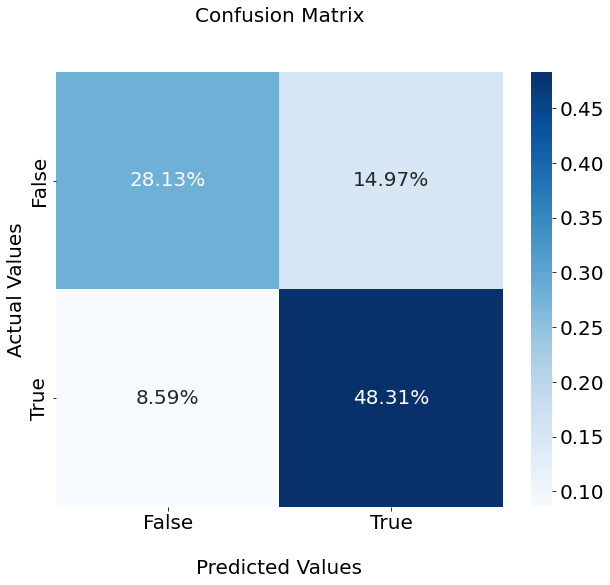

In [33]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_baseline)

## (4.2) With PCA

In [34]:
start_time = timeit.default_timer() # calculate time of execution

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

stop_time = timeit.default_timer()

print(stop_time - start_time, 'seconds')
print(accuracy_pca)

10.490616899999964 seconds
0.7588652482269503


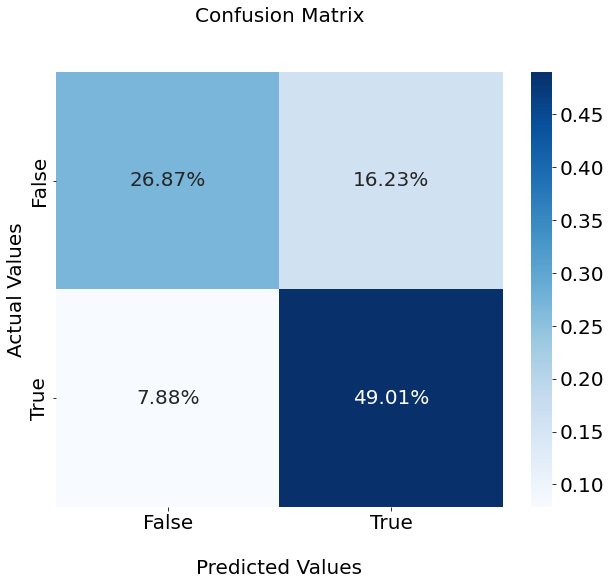

In [29]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_pca)

## (4.3) Hyperparameter optimization

In [19]:
ht1 = HyperTuner(X_train, y_train, 'RandomForestClassifier')

In [20]:
ht1.fit_predict()

The best set of parameteres is: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
The best test score is : 0.7618027760040983
The best train score is : 0.9988420155909647


In [ ]:
ht1.best_params_and_results[0]

In [ ]:
abs_path = os.getcwd()
path = os.path.join(abs_path, 'hyp_tun_res11')

In [ ]:
os.path.exists(path)

## (4.4) Optimized case

The best set of parameteres is: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

In [35]:
opt_hyperparameters = {
    'bootstrap': False, 
    'criterion': 'entropy', 
    'max_depth': 30, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 500}

In [36]:
start_time = timeit.default_timer() # calculate time of execution

rf_opt = RandomForestClassifier(**opt_hyperparameters, random_state=SEED)
rf_opt.fit(X_train, y_train)
y_pred_opt = rf_opt.predict(X_test)
accuracy_opt = accuracy_score(y_test, y_pred_opt)

stop_time = timeit.default_timer()

print(stop_time - start_time, 'seconds')
print(accuracy_opt)

21.441128999999933 seconds
0.7698975571315997


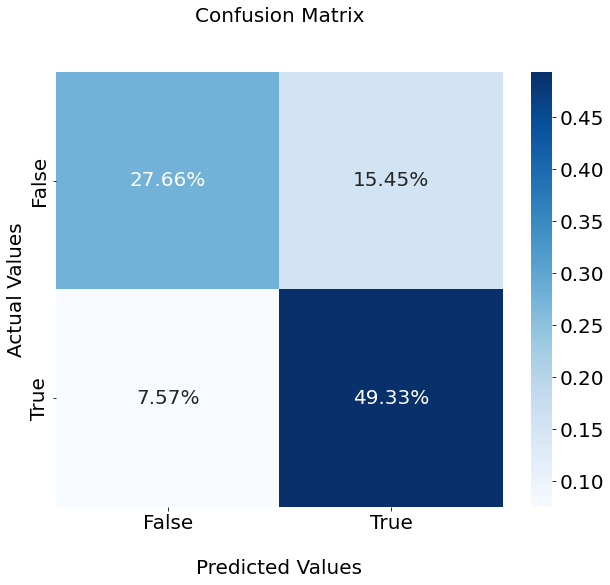

In [22]:
Visualizer.plot_confsuion_matrix(y_test, y_pred_opt)